In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.vision.all import *
from fastai.imports import *
from torchvision.utils import save_image

In [3]:
#import train and test data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
#Normalize
train.iloc[:,1:] = train.iloc[:,1:]/255
test = test/255

In [5]:
#Function to convert a vector representation of an image to tensor
def vetcor_to_image(vector, shape):
    image_matrix = tensor(vector).reshape(shape)
    return(image_matrix)

In [6]:
path = Path('/kaggle/input/digit-recognizer')
Path.BASE_PATH = path

In [7]:
#convert training data to images
path = Path('train')
if not path.exists():
    path.mkdir()
for i in range(train.shape[0]):
    img = vetcor_to_image(train.iloc[i,1:], shape=(28,28))
    dest = (path/train['label'][i].astype(str))
    dest.mkdir(exist_ok=True)
    save_image(img,f'{dest}/{i}.png')

In [8]:
#convert test data to images
path = Path('test')
if not path.exists():
    path.mkdir()
for i in range(test.shape[0]):
    img = vetcor_to_image(test.iloc[i,:], shape=(28,28))
    save_image(img,f'{path}/{i}.png')

In [9]:
#create datablock & dataloaders
path = Path('train')
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=RandomSplitter(seed=42))
dls = dblock.dataloaders(path)

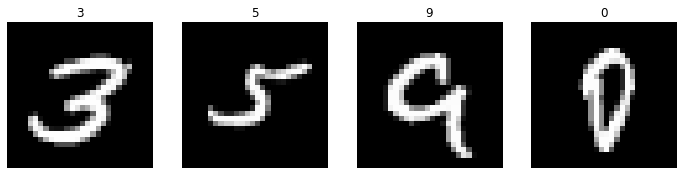

In [10]:
dls.show_batch(max_n=4, nrows=1)

In [11]:
#create model
learner = cnn_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.914021,0.652237,0.205714,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.210030,0.128583,0.037976,00:46
1,0.130067,0.077261,0.023214,00:45
2,0.066181,0.065192,0.019286,00:45
3,0.022415,0.050615,0.014524,00:46
4,0.016385,0.046414,0.013333,00:45


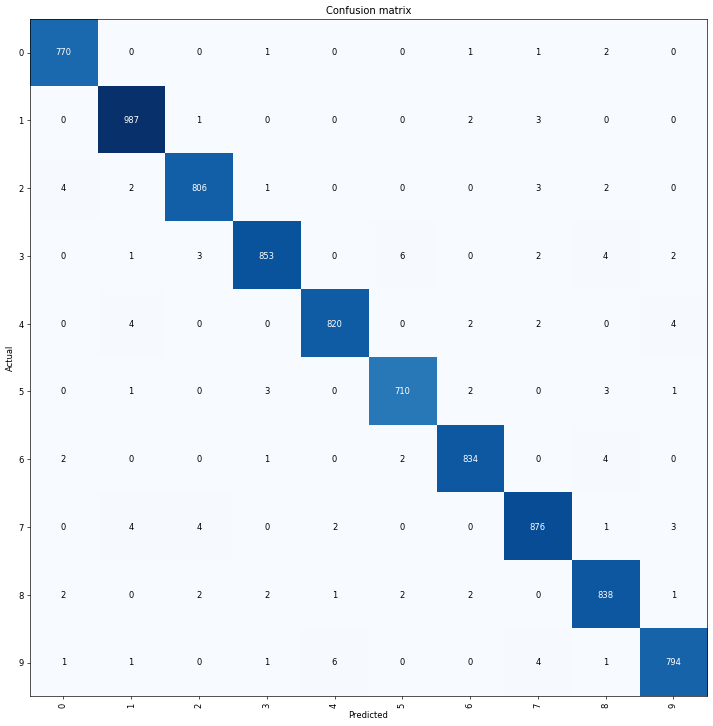

In [12]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
#Items misclassified in most number of times
interp.most_confused(min_val=3)

[('3', '5', 6),
 ('9', '4', 6),
 ('2', '0', 4),
 ('3', '8', 4),
 ('4', '1', 4),
 ('4', '9', 4),
 ('6', '8', 4),
 ('7', '1', 4),
 ('7', '2', 4),
 ('9', '7', 4),
 ('1', '7', 3),
 ('2', '7', 3),
 ('3', '2', 3),
 ('5', '3', 3),
 ('5', '8', 3),
 ('7', '9', 3)]

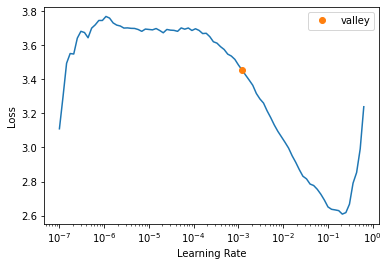

In [14]:
#Finding learning rate
learner = cnn_learner(dls, resnet18, metrics=error_rate)
lr_steep = learner.lr_find()

Best learning rate and default learning rate are same

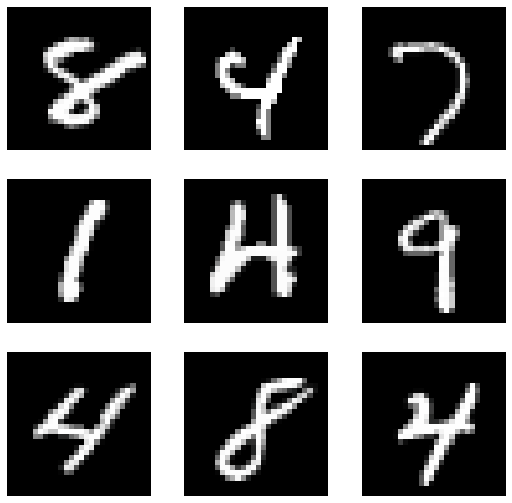

In [15]:
#Prediction on test set
path = Path('test')
test_files = get_image_files(path)
test_dl = dls.test_dl(test_files)
test_dl.show_batch()

In [16]:
pred_probas, _, pred_classes = learner.get_preds(dl=test_dl, with_decoded=True)

In [22]:
#order the test prediction labels
test_label = [0]*len(test_files)
for i, item in enumerate(test_files):
    test_label[int(str(test_files[i]).split('.')[0].split('/')[-1])]=pred_classes[i].item()

In [24]:
test_submission = pd.DataFrame({'ImageId':list(range(1,len(test_files)+1)), 'Label':test_label})
test_submission.to_csv('/kaggle/working/test_predictions.csv', index=False)